In [8]:
import numpy as np
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
%matplotlib inline

import sys, os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *
from registration_utilities import *
from metadata import *

Levelset method to interpolate does not work, as demonstrated by the following simple shift example.

In [9]:
cnt1 = np.array([(1117.28949984232, 1931.6519169809123), (1118.2730293316179, 1868.7060296658522), (1162.5318563500196, 1833.2989680511307), (1191.0542115396563, 1793.9577884792182), (1234.3295090687602, 1724.127194739073), (1262.851864258397, 1636.5930701915674), (1288.4236309801402, 1504.80011862566), (1368.0895196132633, 1496.9318827112772), (1424.1507005032388, 1579.548359812294), (1412.348346631665, 1711.3413113782015), (1366.1224606346677, 1830.3483795832374), (1302.1930438303095, 1926.7342695344234), (1269.7365706834817, 2008.3672171461421), 
                 (1223.5106846864842, 2037.8731018250767), (1188.1036230717627, 2032.9554543785875), (1148.7624434998502, 1988.6966273601859)])
# cnt2 = [(1114.3389113744265, 2030.0048659106942), (1087.7836151633855, 1954.2730952347622), (1132.0424421817872, 1915.9154451521474), (1203.840094900528, 1826.414261626046), (1230.3953911115689, 1734.946019121349), (1246.131862940334, 1677.9013087420756), (1259.9012757905034, 1568.729535430018), (1281.5389245550555, 1491.0307057754903), (1343.5012823808179, 1505.7836481149577), (1369.073049102561, 1580.5318893015917), (1348.418929827307, 1715.2754293353928), (1317.9295156590747, 1911.981327194956), (1286.4565720015446, 2010.3342761247377), (1266.785982215588, 2101.802518629435), (1209.7412718363148, 2130.3248738190714), (1179.2518576680825, 2138.193109733454), (1155.6471499249349, 2092.9507532257544)]
cnt2 = cnt1 + (500,0)

In [10]:
def contours_to_mask(cnts):
    
    inside_xys_all_contours = [points_inside_contour(np.round(cnt).astype(np.int)) for cnt in cnts]
    
    inside_xys_all = np.concatenate(inside_xys_all_contours)
    
    xmin, ymin = inside_xys_all.min(axis=0)
    xmax, ymax = inside_xys_all.max(axis=0)
    w = xmax + 1 - xmin
    h = ymax + 1 - ymin
    
    mask = np.zeros((h, w), np.bool)
    mask[inside_xys_all[:,1] - ymin, inside_xys_all[:,0] - xmin] = 1
    
    return mask

def contours_dict_to_mask(contours_dict, output_multiple_masks=True):
    
    inside_xys_all_contours = {label: [points_inside_contour(np.round(cnt).astype(np.int)) for cnt in contours] 
                               for label, contours in contours_dict.iteritems()}
        
    inside_xys_all = np.concatenate([np.concatenate(contours) 
                                     for contours in inside_xys_all_contours.itervalues()])
    
    xmin, ymin = inside_xys_all.min(axis=0)
    xmax, ymax = inside_xys_all.max(axis=0)
    w = xmax + 1 - xmin
    h = ymax + 1 - ymin
    
    if output_multiple_masks:
        
        masks = {}
        for label, contours in inside_xys_all_contours.iteritems():
            mask = np.zeros((h, w), np.int)
            inside_xys_this_label = np.concatenate(contours)
            mask[inside_xys_this_label[:,1] - ymin, inside_xys_this_label[:,0] - xmin] = label
            masks[label] = mask
            
        return masks
        
    else:
    
        mask = np.zeros((h, w), np.int)

        for label, contours in inside_xys_all_contours.iteritems():
            inside_xys_this_label = np.concatenate(contours)
            mask[inside_xys_this_label[:,1] - ymin, inside_xys_this_label[:,0] - xmin] = label
    
        return mask

In [11]:
def interpolate_contours(cnt1, cnt2, n_levels):
    """
    n_levels include cnt1 and cnt2
    """
    
    masks = contours_dict_to_mask({1: [cnt1], 2: [cnt2]})

    levelset = np.zeros(masks[1].shape + (10,))

    levelset[..., 0] = masks[1].astype(np.float)
    levelset[..., -1] = masks[2].astype(np.float)

    r = np.linspace(0, 1, n_levels)

    m1 = masks[1].astype(np.float).flatten()
    m2 = masks[2].astype(np.float).flatten()

    levelset_flattened = np.outer(r, m1) + np.outer(1-r, m2)
    levelset = np.reshape(levelset_flattened, (len(r), ) + masks[1].shape)

    interpolated_contours = []
    for l, levelfunc in enumerate(levelset):
        interpolate_mask = levelfunc > 0.5
        plt.imshow(levelfunc, cmap=plt.cm.gray)
#         plt.imshow(interpolate_mask, cmap=plt.cm.gray)
        plt.show()
        interpolated_contours.append(find_contour_points(interpolate_mask.astype(np.int))[1])
        
    return interpolated_contours

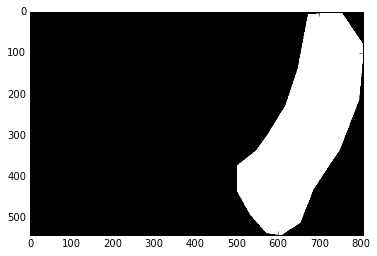

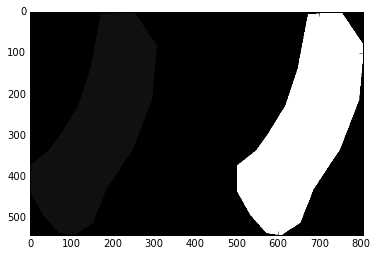

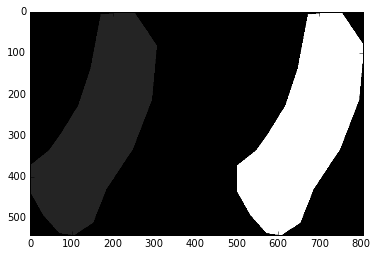

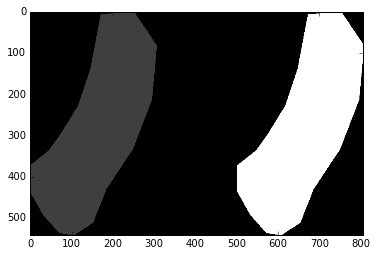

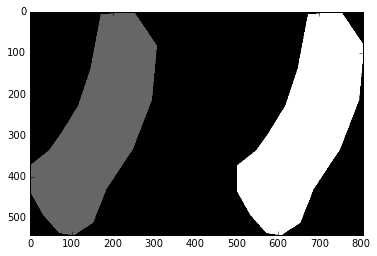

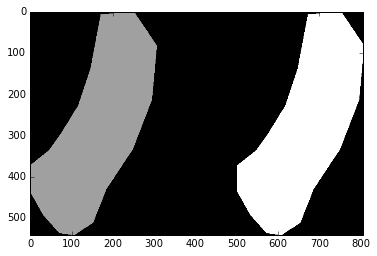

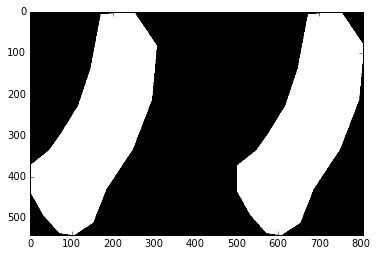

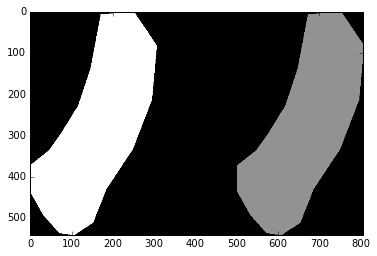

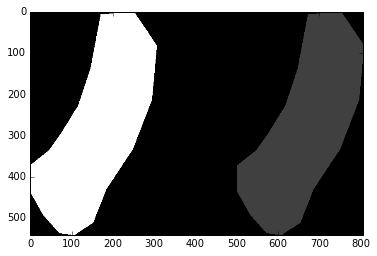

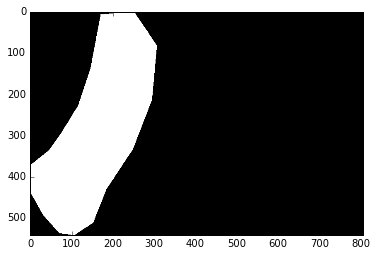

In [12]:
interpolated_contours = interpolate_contours(cnt1, cnt2, n_levels=10)

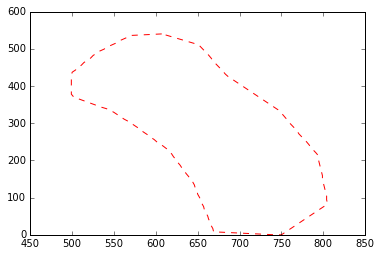

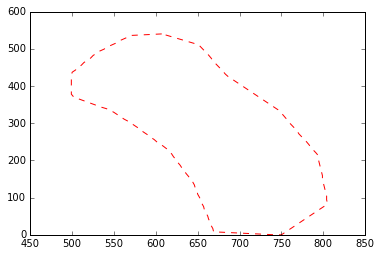

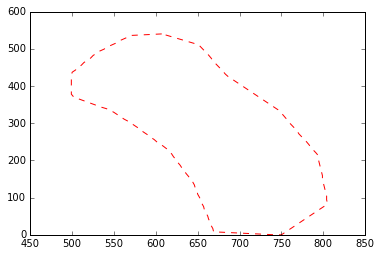

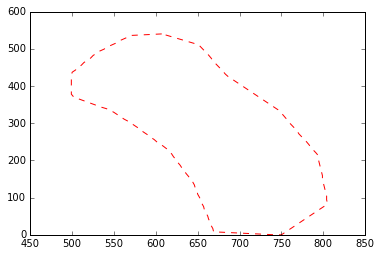

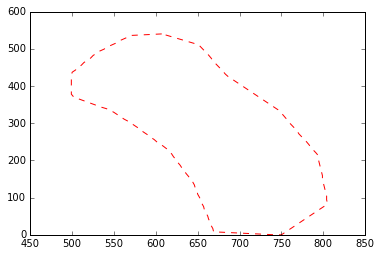

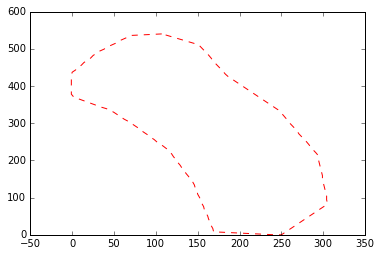

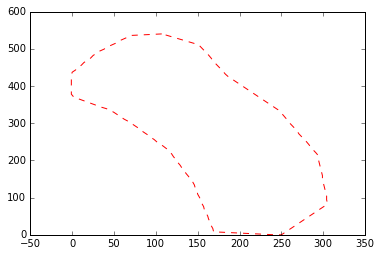

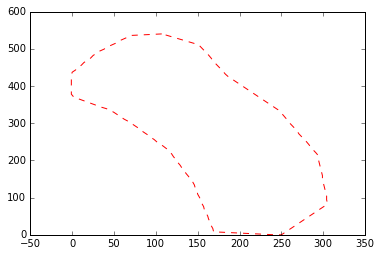

In [13]:
for cnts in interpolated_contours:
    if len(cnts) == 1:
        cnt = cnts[0]
        plt.plot(cnt[:,0], cnt[:,1], '--r')
        plt.show();